In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import boto3

## Load the dataset

In [2]:

def loadDataH5(filepath):
    with h5py.File(filepath,'r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        testX = np.array(hf.get('valX'))
        testY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (testX.shape,testY.shape)
    return trainX, trainY, testX, testY

file_path = 'earth_data.h5'
trainX, trainY, testX, testY = loadDataH5(file_path)

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Visualize the dataset

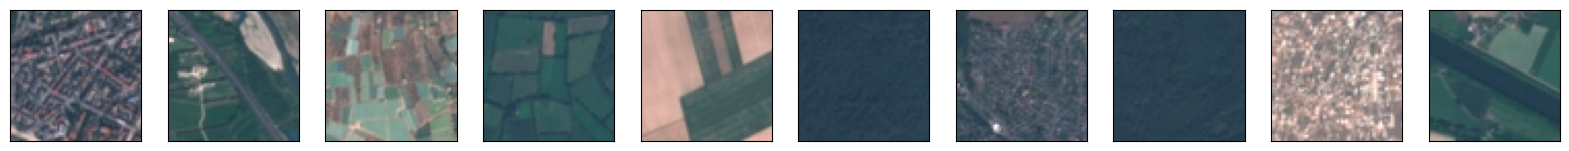

In [3]:
def visualize_images(images, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
visualize_images(trainX)

## Get subset of the dataset

In [4]:

def get_subset(trainX, trainY, testX, testY, fraction=0.3, seed=42):
    # Calculate the number of samples for the given fraction of the dataset
    train_size = int(fraction * trainX.shape[0])
    val_size = int(fraction * testX.shape[0])
    
    # Shuffle the datasets
    np.random.seed(seed)
    train_indices = np.random.permutation(trainX.shape[0])
    val_indices = np.random.permutation(testX.shape[0])
    
    # Select the given fraction of the data
    trainX_subset = trainX[train_indices[:train_size]]
    trainX_subset = trainX_subset.astype("float")/255.0 #normalizing training dataset
    trainY_subset = trainY[train_indices[:train_size]]
    testX_subset = testX[val_indices[:val_size]]
    testX_subset = testX_subset.astype("float")/255.0 #normalizing validation dataset
    testY_subset = testY[val_indices[:val_size]]
    
    return trainX_subset, trainY_subset, testX_subset, testY_subset

trainX_subset, trainY_subset, testX_subset, testY_subset = get_subset(trainX, trainY, testX, testY)
print(trainX_subset.shape, testX_subset.shape)

(5760, 64, 64, 3) (1440, 64, 64, 3)


## Convert the dataset to parquet so it can be uploaded to s3

In [7]:
def save_to_parquet(trainX, trainY, testX, testY):
    
    base_dir = 'data/'
    trainX_path = base_dir + 'trainX.parquet'
    trainY_path = base_dir + 'trainY.parquet'
    testX_path = base_dir + 'testX.parquet'
    testY_path = base_dir + 'testY.parquet'

    trainX_df = pd.DataFrame(trainX.reshape(trainX.shape[0], -1))
    trainY_df = pd.DataFrame(trainY, columns=['label'])
    testX_df = pd.DataFrame(testX.reshape(testX.shape[0], -1))
    testY_df = pd.DataFrame(testY, columns=['label'])
    
    trainX_df.to_parquet(trainX_path, index=False)
    trainY_df.to_parquet(trainY_path, index=False)
    testX_df.to_parquet(testX_path, index=False)
    testY_df.to_parquet(testY_path, index=False)


save_to_parquet(trainX_subset, trainY_subset, testX_subset, testY_subset)

## Upload dataset to s3 bucket. 

In [8]:
def upload_to_s3(s3_path, file_path, bucket_name = 'modeldata1234567'):
    s3 = boto3.client('s3')
    s3.upload_file(file_path, bucket_name, s3_path)
    
    
base_dir = 'data/'
upload_to_s3('train/trainX.parquet', base_dir +  'trainX.parquet')
upload_to_s3('train/trainY.parquet', base_dir + 'trainY.parquet')
upload_to_s3('test/testX.parquet', base_dir + 'testX.parquet')
upload_to_s3('test/testY.parquet', base_dir + 'testY.parquet')